# Configuration

In [273]:
config = [
    
"--experimentdir", "/home/schindlera/experiments/Birdclef2020/experiments/",
"--modeldir"     , "/home/schindlera/experiments/Birdclef2020/experiments/dev6",
    
"--metadata"     , "metadata_final.csv", 
"--audio"        , "melspec_128x192x1_1.115s.npz", 
    
"--model"        , "model1",     
"--gpu"          , "0",
        
"--epochs"       , "500", 
"--learnrate"    , "0.0001",
"--batchsize"    , "36"
    
]

# Data Loading & Preprocessing

In [274]:
import sys
import argparse
import logging

In [275]:

parser = argparse.ArgumentParser()

parser.add_argument('--metadata',     type=str)
parser.add_argument('--model',         type=str)
parser.add_argument('--audio',         type=str)
parser.add_argument('--experimentdir', type=str)
parser.add_argument('--modeldir',      type=str)
parser.add_argument('--gpu',           type=int)
parser.add_argument('--batchsize',     type=int, default=1000)
parser.add_argument('--learnrate',     type=float, default=0.0001)
parser.add_argument('--epochs',        type=int, default=100)
parser.add_argument("--log-level", default=logging.DEBUG, type=lambda x: getattr(logger, x), help="Configure the logger level.")

if sys.argv[0].find("ipykernel_launcher") != -1:
    args = parser.parse_args(config)
else:
    args = parser.parse_args()

# Imports

In [276]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu)

import json

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

In [277]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from numpy.random import seed
from scipy.spatial.distance import cdist
from sklearn.model_selection import GroupShuffleSplit, ShuffleSplit
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger
from tensorflow.keras.constraints import MinMaxNorm, unit_norm
from tensorflow.keras.initializers import he_normal, he_uniform
from tensorflow.keras.layers import (ELU, AlphaDropout, AveragePooling2D,
                                     BatchNormalization, Concatenate, Conv2D,
                                     Dense, Dropout, Flatten, GaussianNoise,
                                     GlobalAveragePooling2D, Input, Lambda,
                                     LeakyReLU, MaxPooling2D, ReLU,
                                     SpatialDropout2D)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adagrad, Adam, Nadam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import normalize
from tensorflow.python.framework import dtypes
from tensorflow.python.ops import array_ops, math_ops

import tensorflow_addons as tfa

In [278]:
# control random processes
np.random.seed(1)

# Functions

In [279]:
def prepare_model_dir(model_path):
    if not os.path.exists(model_path):
        os.makedirs(model_path)

# Initialize Experiment

## Init Logger

In [280]:
logger = logging.getLogger("experiment.py")
logger.setLevel(logging.DEBUG)

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

ch = logging.StreamHandler(sys.stdout)
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)
logger.addHandler(ch)

logger.info("+------------------------------------------------------------------+")
logger.info("| STARTING EXPERIMENT                                              |")
logger.info("+------------------------------------------------------------------+")
logger.info("Logger initialized")

logger.info("Initializing model experiment directory")
model_storage_path = prepare_model_dir(args.modeldir)

logger.info("Initializing logger filehandler")
fh = logging.FileHandler("%s/experiment.log" % args.modeldir)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

2020-05-14 22:17:33 - experiment.py - INFO - +------------------------------------------------------------------+
2020-05-14 22:17:33 - experiment.py - INFO - +------------------------------------------------------------------+
2020-05-14 22:17:33 - experiment.py - INFO - | STARTING EXPERIMENT                                              |
2020-05-14 22:17:33 - experiment.py - INFO - | STARTING EXPERIMENT                                              |
2020-05-14 22:17:33 - experiment.py - INFO - +------------------------------------------------------------------+
2020-05-14 22:17:33 - experiment.py - INFO - +------------------------------------------------------------------+
2020-05-14 22:17:33 - experiment.py - INFO - Logger initialized
2020-05-14 22:17:33 - experiment.py - INFO - Logger initialized
2020-05-14 22:17:33 - experiment.py - INFO - Initializing model experiment directory
2020-05-14 22:17:33 - experiment.py - INFO - Initializing model experiment directory
2020-05-14 22:17:3

Print Experiment Summary

In [281]:
logger.info("+------------------------------------------------------------------+")
logger.info("| EXPERIMENT:                                                      |")
logger.info("+------------------------------------------------------------------+")
logger.info("| Experiment directory              : %s"           % args.experimentdir)
logger.info("| Model-Directory                   : %s"           % args.modeldir)
logger.info("| Metadata filename                 : %s"           % args.metadata)
logger.info("| Audio-Features filename           : %s"           % args.audio)
logger.info("| GPU                               : %d"           % args.gpu)
logger.info("+------------------------------------------------------------------+")
logger.info("| Learn Rate                        : %f"           % args.learnrate)
logger.info("| Batch Size                        : %d"           % args.batchsize)
logger.info("| Num Epochs                        : %d"           % args.epochs)
logger.info("+------------------------------------------------------------------+")

2020-05-14 22:17:33 - experiment.py - INFO - +------------------------------------------------------------------+
2020-05-14 22:17:33 - experiment.py - INFO - +------------------------------------------------------------------+
2020-05-14 22:17:33 - experiment.py - INFO - | EXPERIMENT:                                                      |
2020-05-14 22:17:33 - experiment.py - INFO - | EXPERIMENT:                                                      |
2020-05-14 22:17:33 - experiment.py - INFO - +------------------------------------------------------------------+
2020-05-14 22:17:33 - experiment.py - INFO - +------------------------------------------------------------------+
2020-05-14 22:17:33 - experiment.py - INFO - | Experiment directory              : /home/schindlera/experiments/Birdclef2020/experiments/
2020-05-14 22:17:33 - experiment.py - INFO - | Experiment directory              : /home/schindlera/experiments/Birdclef2020/experiments/
2020-05-14 22:17:33 - experiment.py - IN

Store configuration for reproducability

In [282]:
with open("%s/experiment_arguments.json" % args.modeldir, 'w') as json_file:
    args_json = json.dump(vars(args), json_file)

## Load Audio Data

In [283]:
logger.info("* Load Audio Data")

2020-05-14 22:17:35 - experiment.py - INFO - * Load Audio Data
2020-05-14 22:17:35 - experiment.py - INFO - * Load Audio Data


Load Audio Data - Train Partition

In [284]:
%%time
logger.info("* Load Audio Data")

# load audio content
par_filename_audio_train = "%s/%s" % (args.experimentdir, args.audio)

with np.load(par_filename_audio_train, allow_pickle=True) as npz:
    data_audio_train      = npz["data"]
    track_ids_audio_train = npz["track_ids"].astype(str)
    
lookup_audio_train = pd.DataFrame(np.arange(track_ids_audio_train.shape[0], dtype=int), 
                                  index   = track_ids_audio_train, 
                                  columns = ["feature_line_nr"])

2020-05-14 22:17:35 - experiment.py - INFO - * Load Audio Data
2020-05-14 22:17:35 - experiment.py - INFO - * Load Audio Data
CPU times: user 6.92 s, sys: 2.5 s, total: 9.43 s
Wall time: 9.41 s


In [285]:
# CHECK: ids and data have same length
assert(data_audio_train.shape[0] == track_ids_audio_train.shape[0])

## Load Metadata

In [286]:
logger.info("* Load Metadata")

2020-05-14 22:17:44 - experiment.py - INFO - * Load Metadata
2020-05-14 22:17:44 - experiment.py - INFO - * Load Metadata


Train Partition

In [287]:
metadata = pd.read_csv(f"{args.experimentdir}/{args.metadata}", index_col=0)
metadata["track_id"] = metadata.filename.str.replace(".mp3", "")
metadata = metadata.set_index("track_id")

metadata = metadata.loc[metadata.index.intersection(track_ids_audio_train)]

metadata["feature_line_nr"] = lookup_audio_train.loc[metadata.index]

metadata.FAMILY = metadata.FAMILY.str.split("(").str[0]

In [288]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit

In [289]:
enc_species = LabelEncoder()
enc_family  = LabelEncoder()
enc_order1  = LabelEncoder()

In [290]:
enc_species = enc_species.fit(metadata["ebird code"])
enc_family = enc_family.fit(metadata.FAMILY)
enc_order1 = enc_order1.fit(metadata.ORDER1)

In [291]:
labels_enc_species = enc_species.transform(metadata["ebird code"])
labels_enc_family  = enc_family.transform(metadata.FAMILY)
labels_enc_order1  = enc_order1.transform(metadata.ORDER1)

In [292]:
ohe_species = OneHotEncoder(sparse=False)
ohe_family  = OneHotEncoder(sparse=False)
ohe_order1  = OneHotEncoder(sparse=False)

In [293]:
ohe_enc_species = ohe_species.fit_transform(labels_enc_species.reshape(-1, 1))
ohe_enc_family  = ohe_family.fit_transform(labels_enc_family.reshape(-1, 1) )
ohe_enc_order1  = ohe_order1.fit_transform(labels_enc_order1.reshape(-1, 1) )

In [294]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=0)

In [295]:
train_idx, val_idx = list(sss.split(np.ones((labels_enc_species.shape[0],1)), labels_enc_family))[0]

In [296]:
logger.info("Num instances - train : %d" % train_idx.shape[0])
logger.info("Num instances - val   : %d" % val_idx.shape[0])
logger.info("+------------------------------------------------------------------+")

2020-05-14 22:17:46 - experiment.py - INFO - Num instances - train : 68326
2020-05-14 22:17:46 - experiment.py - INFO - Num instances - train : 68326
2020-05-14 22:17:46 - experiment.py - INFO - Num instances - val   : 3597
2020-05-14 22:17:46 - experiment.py - INFO - Num instances - val   : 3597
2020-05-14 22:17:46 - experiment.py - INFO - +------------------------------------------------------------------+
2020-05-14 22:17:46 - experiment.py - INFO - +------------------------------------------------------------------+


# Model

# Model

In [297]:
class LoggerCallback(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs=None):
        logger.info("+------------------------------------------------------------------+")
        logger.info("| TRAINING BEGIN                                                   |")
        logger.info("+------------------------------------------------------------------+")

    def on_epoch_end(self, epoch, logs=None):
        logger.info('Epoch %d: train_loss %f - val_loss %f' % (epoch, logs['loss'], logs['val_loss']))

    def on_train_end(self, logs=None):
        logger.info("+------------------------------------------------------------------+")
        logger.info("| TRAINING END                                                     |")
        logger.info("+------------------------------------------------------------------+")

In [298]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.constraints import MinMaxNorm, unit_norm
from tensorflow.keras.initializers import he_normal, he_uniform, glorot_uniform
from tensorflow.keras.layers import (ELU, AlphaDropout, AveragePooling2D,
                                     BatchNormalization, Concatenate, Conv2D,
                                     Dense, Dropout, Flatten, GaussianNoise,
                                     GlobalAveragePooling2D, Input, Lambda,
                                     LeakyReLU, MaxPooling2D, ReLU,
                                     SpatialDropout2D)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adagrad, Adam, Nadam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import normalize
from tensorflow.python.framework import dtypes
from tensorflow.python.ops import array_ops, math_ops

In [299]:
def get_model():
    
    # --- input layers
    input_ref = Input((128,192,1), name="input_ref") # reference track

    # --- input pre-processing
    bn_inp = BatchNormalization(name="bnorm_input")(input_ref)
    #bn_inp = GaussianNoise(0.3)(bn_inp)

    cnn  = Conv2D(12, (3,3), padding="same", kernel_initializer=glorot_uniform(1))(bn_inp)
    cnn = BatchNormalization()(cnn)
    cnn = ELU()(cnn)
    cnn = MaxPooling2D((2,3))(cnn)

    cnn  = Conv2D(24, (3,3), padding="same", kernel_initializer=glorot_uniform(2))(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = ELU()(cnn)
    cnn = MaxPooling2D((2,2))(cnn)

    cnn  = Conv2D(48, (3,3), padding="same", kernel_initializer=glorot_uniform(3))(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = ELU()(cnn)
    cnn = MaxPooling2D((2,2))(cnn)

    cnn  = Conv2D(96, (3,3), padding="same", kernel_initializer=glorot_uniform(4))(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = ELU()(cnn)
    cnn = MaxPooling2D((2,2))(cnn)

    cnn  = Conv2D(192, (3,3), padding="same", kernel_initializer=glorot_uniform(5))(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = ELU()(cnn)
    cnn = MaxPooling2D((2,2))(cnn)

    #cnn  = Conv2D(256, (1,1), padding="same", kernel_initializer=glorot_uniform(6))(cnn)
    #cnn = BatchNormalization()(cnn)
    #cnn = ELU()(cnn)


    flat = Flatten()(cnn)

    fc1 = Dense(256, activation="elu", kernel_initializer=glorot_uniform(7))(flat)
    
    do1 = Dropout(0.5, seed=1)(fc1)
    
    fc2 = Dense(256, activation="elu", kernel_initializer=glorot_uniform(7))(do1)

    do2 = Dropout(0.5, seed=1)(fc2)
    
    
    order1  = Dense(ohe_enc_order1.shape[1], activation="softmax", kernel_initializer=glorot_uniform(7), name="order1")(flat)
    
    family  = Dense(ohe_enc_family.shape[1], activation="softmax", kernel_initializer=glorot_uniform(7), name="family")(do1)
    
    species = Dense(ohe_enc_species.shape[1], activation="softmax", kernel_initializer=glorot_uniform(7), name="species")(do2)

    # --- build model
    model   = Model(inputs=[input_ref], outputs=[order1, family, species])

    return model
    

In [300]:
model = get_model()
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ref (InputLayer)          [(None, 128, 192, 1) 0                                            
__________________________________________________________________________________________________
bnorm_input (BatchNormalization (None, 128, 192, 1)  4           input_ref[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 128, 192, 12) 120         bnorm_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 128, 192, 12) 48          conv2d_15[0][0]                  
____________________________________________________________________________________________

In [301]:
# ===============================================================================
# # Train Model
# ===============================================================================

logger.info("* Prepare Evaluation")

# ===============================================================================
# ### Build and Train Model
# ===============================================================================

# define the model
model = get_model()

logger.info("* Model created")

# define the optimizer
opt = Adam(lr=args.learnrate)
#opt = SGD(lr=0.0001)
#opt = tfa.optimizers.RectifiedAdam(lr=1e-4)

logger.info("* Optimizer: %s" % (str(opt)))


#from keras_radam import RAdam

#opt = RAdam(total_steps=10000, warmup_proportion=0.1, learning_rate=1e-4, min_lr=1e-5)

# compile the model
model.compile(loss      = "categorical_crossentropy",
              metrics   = ["accuracy"],
              optimizer = opt)
logger.info("* Model compiled")
                    
# ===============================================================================
# Callbacks
# ===============================================================================

cb_modelcheckpoint = ModelCheckpoint(args.modeldir + "/model.h5", 
                                    monitor           = 'val_loss', 
                                    verbose           = 1, 
                                    save_best_only    = True, 
                                    save_weights_only = True, 
                                    mode              = 'auto')
    
cb_tensorboard =  TensorBoard(log_dir=args.modeldir, 
                                histogram_freq=0, 
                                write_graph=False, 
                                write_grads=False, 
                                write_images=False, 
                                embeddings_freq=0, 
                                embeddings_layer_names=None, 
                                embeddings_metadata=None, 
                                embeddings_data=None, 
                                update_freq='epoch')

cb_csv_logger = CSVLogger(args.modeldir + "/model_training_log.csv", separator=';', append=False)

cb_logger = LoggerCallback()
    
callbacks = [cb_tensorboard, 
             cb_modelcheckpoint, 
             cb_csv_logger, 
             cb_logger]
logger.info("* Callbacks created")

2020-05-14 22:17:47 - experiment.py - INFO - * Prepare Evaluation
2020-05-14 22:17:47 - experiment.py - INFO - * Prepare Evaluation
2020-05-14 22:17:47 - experiment.py - INFO - * Model created
2020-05-14 22:17:47 - experiment.py - INFO - * Model created
2020-05-14 22:17:47 - experiment.py - INFO - * Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f913aa00908>
2020-05-14 22:17:47 - experiment.py - INFO - * Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f913aa00908>
2020-05-14 22:17:47 - experiment.py - INFO - * Model compiled
2020-05-14 22:17:47 - experiment.py - INFO - * Model compiled
2020-05-14 22:17:47 - experiment.py - INFO - * Callbacks created
2020-05-14 22:17:47 - experiment.py - INFO - * Callbacks created


In [302]:
audio_fn_train = metadata.iloc[train_idx].feature_line_nr
audio_fn_val   = metadata.iloc[val_idx].feature_line_nr

In [303]:
logger.info("* Model Training: starting")
# first test - only to debug code
history = model.fit(data_audio_train[audio_fn_train],
                    [ohe_enc_order1[train_idx], ohe_enc_family[train_idx], ohe_enc_species[train_idx]],
                    batch_size       = args.batchsize, 
                    verbose          = 1, 
                    epochs           = args.epochs,
                    validation_data  = (data_audio_train[audio_fn_val], [ohe_enc_order1[val_idx], ohe_enc_family[val_idx], ohe_enc_species[val_idx]]),
                    callbacks        = callbacks,
                    shuffle          = True);

2020-05-14 22:17:47 - experiment.py - INFO - * Model Training: starting
2020-05-14 22:17:47 - experiment.py - INFO - * Model Training: starting
Train on 68326 samples, validate on 3597 samples
2020-05-14 22:17:54 - experiment.py - INFO - +------------------------------------------------------------------+
2020-05-14 22:17:54 - experiment.py - INFO - +------------------------------------------------------------------+
2020-05-14 22:17:54 - experiment.py - INFO - | TRAINING BEGIN                                                   |
2020-05-14 22:17:54 - experiment.py - INFO - | TRAINING BEGIN                                                   |
2020-05-14 22:17:54 - experiment.py - INFO - +------------------------------------------------------------------+
2020-05-14 22:17:54 - experiment.py - INFO - +------------------------------------------------------------------+
Epoch 1/500
68184/68326 [============================>.] - ETA: 0s - loss: 12.7121 - order1_loss: 1.7630 - family_loss: 4.0

KeyError: 'val_family_accuracy'

In [304]:
%matplotlib inline

import matplotlib.pyplot as plt
import librosa as lr
from librosa import display

In [305]:
data_audio_train[audio_fn_val[0]].shape

(128, 192, 1)

In [306]:
idx = audio_fn_val[108]
metadata.iloc[idx]

author              Mauricio Álvarez Rebolledo (Colección de Sonid...
background                                                        NaN
bird_seen                                                         NaN
bitrate of mp3                                           125337 (bps)
channels                                                   2 (stereo)
country                                                      Colombia
date                                                       2004-01-30
description         IAvH-CSA 16227\n\nTo obtain a wav file of the ...
duration                                                           11
ebird code                                                    yehcar1
elevation                                                       250 m
file type                                                         mp3
filename                                                 XC148400.mp3
latitude                                                     4.516667
length              

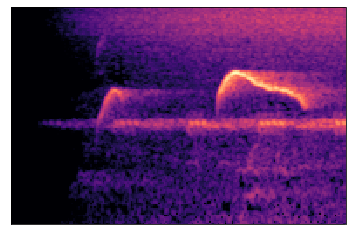

In [307]:
display.specshow(data_audio_train[idx][:,:,0]);

In [308]:
res = model.predict(data_audio_train[[idx]])

In [309]:
enc_species.inverse_transform([np.argmax(res[2])])[0], enc_family.inverse_transform([np.argmax(res[1])])[0], enc_order1.inverse_transform([np.argmax(res[0])])[0]

('redher1', 'Regulidae ', 'Passeriformes')

In [310]:
from vis.visualization import visualize_saliency

In [311]:
from vis.utils import utils

In [312]:
layer_idx = utils.find_layer_idx(model, 'species')

In [313]:
np.argmax(res[2])

644

In [314]:
grad_top1

array([[0.00865756, 0.0236157 , 0.00443794, ..., 0.01079944, 0.06778271,
        0.03330542],
       [0.00663723, 0.01677784, 0.01458106, ..., 0.11376885, 0.0064823 ,
        0.00077305],
       [0.01128244, 0.00531545, 0.00201735, ..., 0.02858122, 0.01852569,
        0.01959785],
       ...,
       [0.01861558, 0.02856269, 0.04614538, ..., 0.07881507, 0.00739111,
        0.00984265],
       [0.00776838, 0.0149427 , 0.03948459, ..., 0.11214126, 0.02613486,
        0.00324744],
       [0.0192555 , 0.00800648, 0.01039366, ..., 0.0211683 , 0.04969696,
        0.02984899]], dtype=float32)

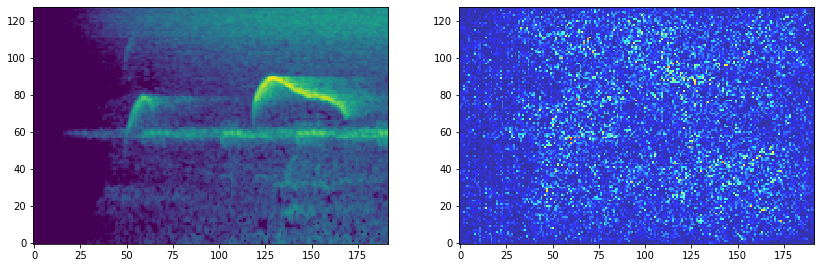

In [315]:
def plot_map(spec):
    
    grads = visualize_saliency(model,
                               layer_idx,
                               filter_indices = np.argmax(res[2]),
                               seed_input     = spec)
    
    fig, axes = plt.subplots(1,2,figsize=(14,5), sharex=True)
    axes[0].imshow(spec[:,:,0], origin=0)
    #axes[1].imshow(spec[:,:,0])
    i = axes[1].imshow(grads,cmap="jet",alpha=0.8, origin=0)
    #fig.colorbar(i)
    
plot_map(data_audio_train[idx])

In [316]:
inp = Input((128,192,3))

lime_out = model(inp[:,:,:,0:1])


model_lime = Model(inputs=inp, outputs=lime_out[2])


model_lime.summary()


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 192, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice_26 [(None, 128, 192, 1)]     0         
_________________________________________________________________
model_8 (Model)              [(None, 25), (None, 94),  1422475   
Total params: 1,422,475
Trainable params: 1,421,729
Non-trainable params: 746
_________________________________________________________________


In [317]:
import lime
from lime import lime_image

In [318]:
explainer = lime_image.LimeImageExplainer()

In [319]:
spec = np.concatenate([data_audio_train[idx], data_audio_train[idx], data_audio_train[idx]], axis=2).astype(np.float64)

explanation = explainer.explain_instance(spec, model_lime.predict, top_labels=np.argmax(res[2]), hide_color=0, num_samples=20000)

np.argmax(res[2])

from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=20, hide_rest=False)
plt.imshow(spec[:,:,0])
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), alpha=0.5, origin=0)

In [324]:
explanation.top_labels[0]

644

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


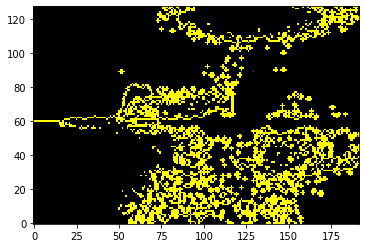

In [325]:


temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), origin=0)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


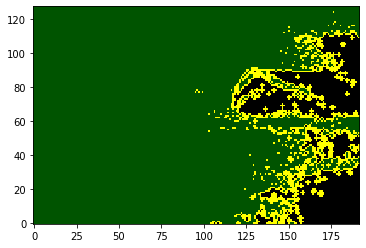

In [326]:


temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), origin=0)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


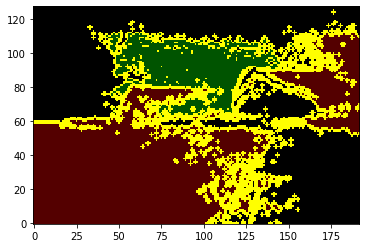

In [327]:


temp, mask = explanation.get_image_and_mask(445, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), origin=0)



In [352]:
val_results_all = model.predict(data_audio_train[audio_fn_val], verbose=True)

3597/3597 [==============================] - 1s 199us/sample


In [353]:
val_results_species = val_results_all[2]

In [369]:
true_positives = np.argmax(val_results_species, axis=1) == labels_enc_species[val_idx]

In [370]:
val_idx[true_positives]

array([28405, 58251,  6123, 54855, 41408, 51461, 59054, 46682, 16326,
       40155, 17610, 13226, 30388, 36440,   424, 56726, 24398, 15294,
       35927, 69177, 26320, 38892, 39097, 53635, 43673, 44506,   763,
       21241, 37901, 34389, 21235, 54435, 49807,  2941, 56043, 70483,
       32226,  2292, 58773,  8763, 53768,  2907, 53708, 28095, 32822,
        7263, 54859, 60253, 40539, 66149, 30106, 65240, 29122, 68719,
       63099, 24708, 55070, 31886, 47552, 56920,  5019, 68836, 59739,
       42045, 49506,   676, 59838, 47114, 49550, 41821, 17281, 17969,
        4574, 12964, 20462, 70475, 57666, 51010, 38891, 45303, 70542,
       60338, 40961, 44271, 24712,  1040,  2910, 56297, 61255, 12760,
       52349, 36649, 59306, 53103, 52626,  7258,  7222, 64697, 16105,
       30250, 41507, 19047, 43054, 62140, 36663, 37187, 33832, 56750,
       36055, 32312, 49523, 30842, 68181, 26484, 35253, 52695,  7465,
       14002, 47079, 52898, 26923, 45117, 16166, 39884, 54816,  8511,
       52001, 61788,

In [371]:
train_results_all = model.predict(data_audio_train[audio_fn_train], verbose=True)

68326/68326 [==============================] - 12s 182us/sample


In [372]:
train_results_species = train_results_all[2]

In [373]:
true_positives = np.argmax(train_results_species, axis=1) == labels_enc_species[train_idx]

In [380]:
success_train = train_idx[true_positives]

In [389]:
t = pd.DataFrame(ohe_enc_species, columns=enc_species.inverse_transform(ohe_species.categories_[0])).iloc[success_train].sum(axis=0)
t.sort_values(ascending=False)

bargoo     67.0
eubeat1    64.0
rebnut     61.0
brthum     61.0
bktspa     59.0
           ... 
mastan1     0.0
masyel1     0.0
mccfly1     0.0
mobela1     0.0
agaher1     0.0
Length: 960, dtype: float64

In [439]:
sample = np.random.choice(np.arange(train_idx.shape[0]), 5000, replace=False)

In [440]:
from scipy.spatial.distance import cdist

In [488]:
dists = cdist(train_results_species[sample], train_results_species[sample], metric="euclidean")

In [489]:
np.fill_diagonal(dists, 1000)

In [490]:
row = np.argmin(dists.min(axis=1))
col = np.argmin(dists[row])

In [491]:
row_id = sample[row]
col_id = sample[col]

In [492]:
dists = cdist(train_results_species, train_results_species[[row_id]], metric="euclidean")

In [493]:
col_id = np.argsort(dists[:,0])[1]

In [494]:
track_a = train_idx[row_id]
track_b = train_idx[col_id]

In [498]:
col, row, row_id, col_id, track_a, track_b

(912, 729, 34053, 12408, 54952, 54917)

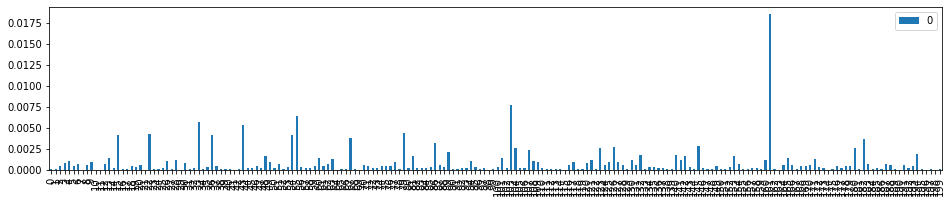

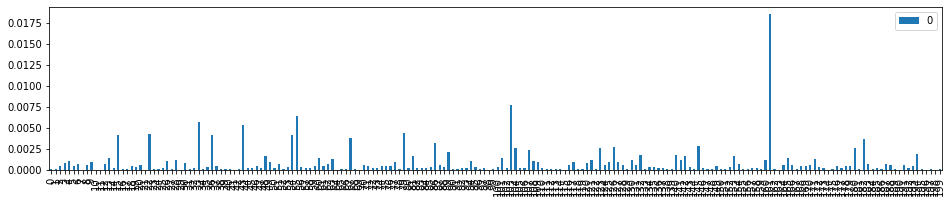

In [525]:
pd.DataFrame(train_results_species[row_id][:200]).plot(kind='bar', figsize=(16,3))

pd.DataFrame(train_results_species[col_id][:200]).plot(kind='bar', figsize=(16,3))

#pd.DataFrame(train_results_species[row_id][:200] - train_results_species[col_id][:200]).plot(kind='bar', figsize=(16,6))

In [501]:
metadata.iloc[[track_a, track_b]].T

,XC504641,XC369869
author,Pedro Rinaldi,Pedro Rinaldi
background,NaN,NaN
bird_seen,NaN,NaN
bitrate of mp3,192553 (bps),192553 (bps)
channels,2 (stereo),2 (stereo)
country,Uruguay,Uruguay
date,2014-12-30,2014-12-11
description,NaN,NaN
duration,9,9
ebird code,snakit,snakit


In [ ]:
from skimage.segmentation import mark_boundaries

In [515]:
spec = np.concatenate([data_audio_train[track_a], 
                       data_audio_train[track_a], 
                       data_audio_train[track_a]], axis=2).astype(np.float64)

explanation = explainer.explain_instance(spec, model_lime.predict, 
                                         top_labels=np.argmax(train_results_species[row_id]), 
                                         hide_color=0, num_samples=5000)

temp_a, mask_a = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, num_features=20, hide_rest=False)

In [516]:
spec = np.concatenate([data_audio_train[track_b], 
                       data_audio_train[track_b], 
                       data_audio_train[track_b]], axis=2).astype(np.float64)

explanation = explainer.explain_instance(spec, model_lime.predict, 
                                         top_labels=np.argmax(train_results_species[col_id]), 
                                         hide_color=0, num_samples=5000)

temp_b, mask_b = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, num_features=20, hide_rest=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


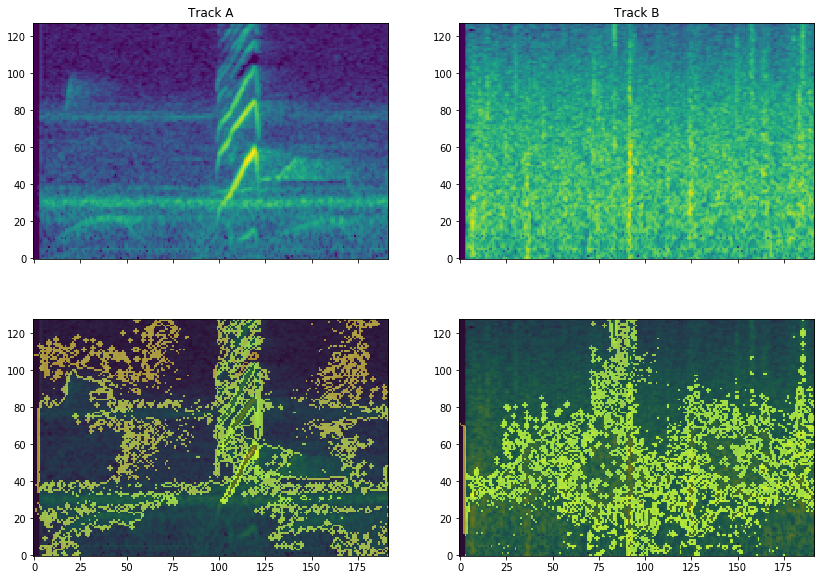

In [524]:
fig, axes = plt.subplots(2,2,figsize=(14,10), sharex=True)

axes[0,0].set_title("Track A")
axes[0,1].set_title("Track B")

axes[0,0].imshow(data_audio_train[track_a][:,:,0], origin=0)
axes[0,1].imshow(data_audio_train[track_b][:,:,0], origin=0)

axes[1,0].imshow(data_audio_train[track_a][:,:,0], origin=0, alpha=0.9)
axes[1,0].imshow(mark_boundaries(temp_a / 2 + 0.5, mask_a), alpha=0.5, origin=0)
axes[1,1].imshow(data_audio_train[track_b][:,:,0], origin=0, alpha=0.9)
axes[1,1].imshow(mark_boundaries(temp_b / 2 + 0.5, mask_b), alpha=0.5, origin=0)

In [526]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ref (InputLayer)          [(None, 128, 192, 1) 0                                            
__________________________________________________________________________________________________
bnorm_input (BatchNormalization (None, 128, 192, 1)  4           input_ref[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 192, 12) 120         bnorm_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 128, 192, 12) 48          conv2d_20[0][0]                  
____________________________________________________________________________________________

In [528]:
layer_idx = utils.find_layer_idx(model, 'flatten_4')
layer_idx

22

In [530]:
model_latent = Model(inputs=model.input, outputs=model.get_layer('flatten_4').output)

In [532]:
emb_spec = model_latent.predict(data_audio_train, verbose=True, batch_size=100)

72226/72226 [==============================] - 8s 107us/sample


In [534]:
emb_spec[track_a]

array([0.28635502, 1.3800681 , 1.5910283 , ..., 0.60498345, 1.1062073 ,
       0.37292272], dtype=float32)

In [569]:
empty_seg_idx = cdist(emb_spec[[track_a]], emb_spec, metric="euclidean")

In [570]:
empty_seg_idx = empty_seg_idx[0,:]

In [571]:
empty_seg_idx = np.argsort(empty_seg_idx)

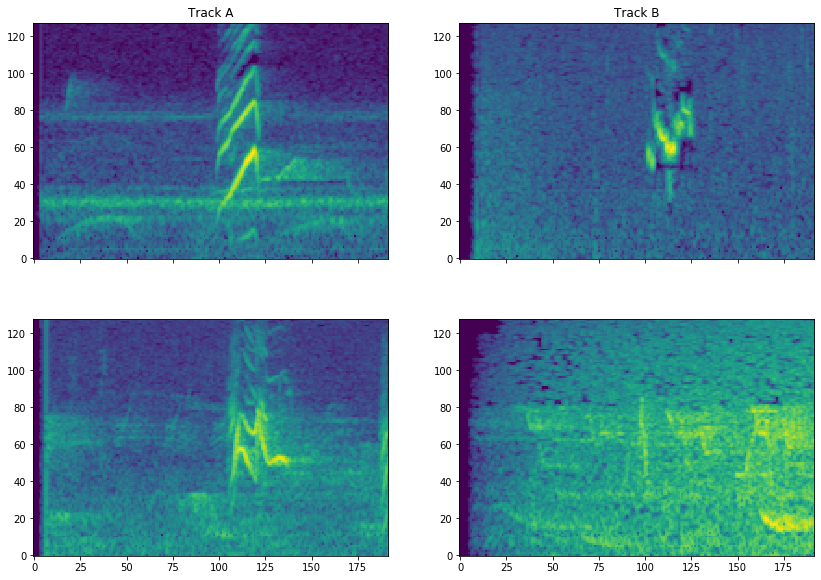

In [575]:
fig, axes = plt.subplots(2,2,figsize=(14,10), sharex=True)

axes[0,0].set_title("Track A")
axes[0,1].set_title("Track B")

axes[0,0].imshow(data_audio_train[empty_seg_idx[0]][:,:,0], origin=0)
axes[0,1].imshow(data_audio_train[empty_seg_idx[1]][:,:,0], origin=0)

axes[1,0].imshow(data_audio_train[empty_seg_idx[2]][:,:,0], origin=0)
axes[1,1].imshow(data_audio_train[empty_seg_idx[5000]][:,:,0], origin=0)

In [576]:
play_audio(empty_seg_idx[5000])

In [614]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [583]:
pca = PCA(n_components=128)
pca.fit(emb_spec)

PCA(copy=True, iterated_power='auto', n_components=128, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [584]:
emb_spec_pca = pca.transform(emb_spec)

In [660]:
dbs = DBSCAN(eps=0.05, metric='cosine', n_jobs=10)

dbs.fit(emb_spec_pca)

clusters = dbs.labels_

np.unique(clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [616]:
emb_clusters1 = pd.DataFrame(dbs.labels_, columns=["label"])

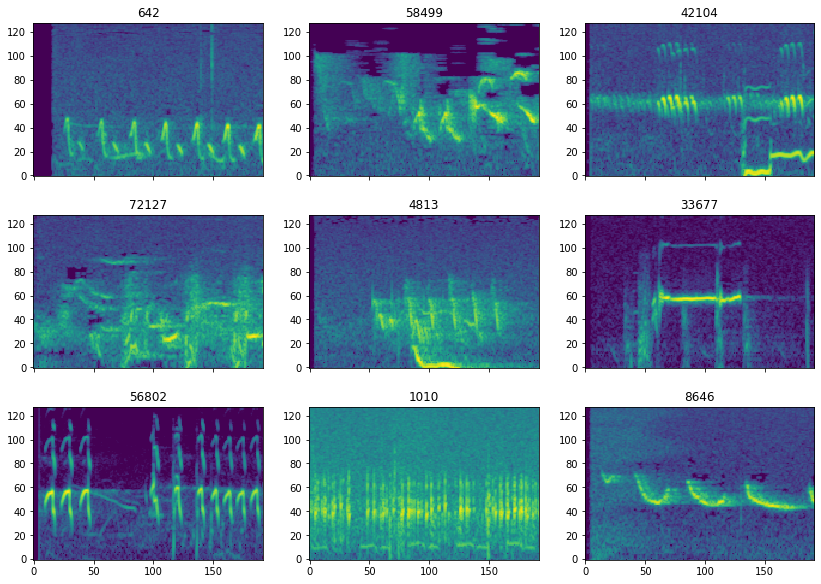

In [712]:
idxs = emb_clusters1[emb_clusters1.label == 1].index
idxs = np.random.choice(idxs, 9)

fig, axes = plt.subplots(3,3,figsize=(14,10), sharex=True)

#axes[0,0].set_title("Track A %d" % idxs[0])
#axes[0,1].set_title("Track B")

axes[0,0].set_title(idxs[0])
axes[0,1].set_title(idxs[1])
axes[0,2].set_title(idxs[2])
axes[1,0].set_title(idxs[3])
axes[1,1].set_title(idxs[4])
axes[1,2].set_title(idxs[5])
axes[2,0].set_title(idxs[6])
axes[2,1].set_title(idxs[7])
axes[2,2].set_title(idxs[8])

norm = plt.Normalize(-80, 0)

axes[0,0].imshow(data_audio_train[idxs[0]][:,:,0], origin=0, norm=norm)
axes[0,1].imshow(data_audio_train[idxs[1]][:,:,0], origin=0, norm=norm)
axes[0,2].imshow(data_audio_train[idxs[2]][:,:,0], origin=0, norm=norm)

axes[1,0].imshow(data_audio_train[idxs[3]][:,:,0], origin=0, norm=norm)
axes[1,1].imshow(data_audio_train[idxs[4]][:,:,0], origin=0, norm=norm)
axes[1,2].imshow(data_audio_train[idxs[5]][:,:,0], origin=0, norm=norm)

axes[2,0].imshow(data_audio_train[idxs[6]][:,:,0], origin=0, norm=norm)
axes[2,1].imshow(data_audio_train[idxs[7]][:,:,0], origin=0, norm=norm)
axes[2,2].imshow(data_audio_train[idxs[8]][:,:,0], origin=0, norm=norm)

In [706]:
dists = cdist(emb_spec, emb_spec[[16687]], metric="euclidean")

In [707]:
dists_idx = np.argsort(dists[:,0])

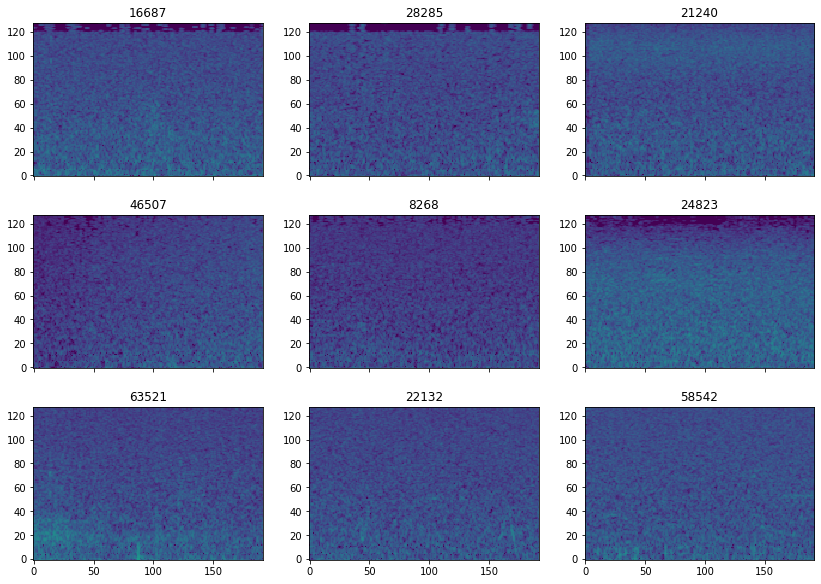

In [708]:
idxs = dists_idx[0:]

fig, axes = plt.subplots(3,3,figsize=(14,10), sharex=True)

#axes[0,0].set_title("Track A %d" % idxs[0])
#axes[0,1].set_title("Track B")

axes[0,0].set_title(idxs[0])
axes[0,1].set_title(idxs[1])
axes[0,2].set_title(idxs[2])
axes[1,0].set_title(idxs[3])
axes[1,1].set_title(idxs[4])
axes[1,2].set_title(idxs[5])
axes[2,0].set_title(idxs[6])
axes[2,1].set_title(idxs[7])
axes[2,2].set_title(idxs[8])

norm = plt.Normalize(-80, 0)

axes[0,0].imshow(data_audio_train[idxs[0]][:,:,0], origin=0, norm=norm)
axes[0,1].imshow(data_audio_train[idxs[1]][:,:,0], origin=0, norm=norm)
axes[0,2].imshow(data_audio_train[idxs[2]][:,:,0], origin=0, norm=norm)

axes[1,0].imshow(data_audio_train[idxs[3]][:,:,0], origin=0, norm=norm)
axes[1,1].imshow(data_audio_train[idxs[4]][:,:,0], origin=0, norm=norm)
axes[1,2].imshow(data_audio_train[idxs[5]][:,:,0], origin=0, norm=norm)

axes[2,0].imshow(data_audio_train[idxs[6]][:,:,0], origin=0, norm=norm)
axes[2,1].imshow(data_audio_train[idxs[7]][:,:,0], origin=0, norm=norm)
axes[2,2].imshow(data_audio_train[idxs[8]][:,:,0], origin=0, norm=norm)

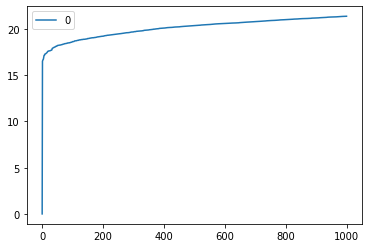

In [702]:
pd.DataFrame(dists[dists_idx][:1000]).plot(kind="line")

In [709]:
model.save_weights(f'{args.experimentdir}/first_model.h5')

In [710]:
np.savez(f'{args.experimentdir}/emb_spec.npz', data=emb_spec)
np.savez(f'{args.experimentdir}/emb_spec_pca.npz', data=emb_spec_pca)

In [567]:
def play_audio(idx):
    
    import librosa as lr
    import IPython.display as ipd
    
    S = lr.feature.inverse.mel_to_audio(data_audio_train[idx][:,:,0], sr=44100, n_fft=1024, hop_length=256)
    return ipd.Audio(S, rate=44100)

In [ ]:
logger.info("* Model Training: completed")

model_path = args.modeldir + "/model.h5"
logger.info("* Loading best model: %s" % model_path)
model.load_weights(model_path)

logger.info("* Inference: Embedding audio data into learned representation")
embeddings_train = model.predict(data_audio_train, batch_size=100, verbose=1)

logger.info("* storing embeddings")
np.savez(args.modeldir + "/final_embeddings_train.npz", data=embeddings_train, track_ids=track_ids_audio_train)

logger.info("* Inference: Embedding audio data into learned representation")
embeddings_val = model.predict(data_audio_val, batch_size=100, verbose=1)

logger.info("* storing embeddings")
np.savez(args.modeldir + "/final_embeddings_val.npz", data=embeddings_val, track_ids=track_ids_audio_val)

del data_audio_train, data_audio_val, embeddings_train, embeddings_val

logger.info("* Load Audio Data - Test Partition")

# load partition trackid file
par_file           = "%s/eval_partition_trackids_test.csv" % (args.experimentdir)
par_trackids_test = pd.read_csv(par_file, header=None, index_col=0)

# load audio content
par_filename_audio_test = "%s/%s_test.npz" % (args.experimentdir, args.audio)

with np.load(par_filename_audio_test, allow_pickle=True) as npz:
    data_audio_test      = npz["data"]
    track_ids_audio_test = npz["track_ids"].astype(str)
    
lookup_audio_test = pd.DataFrame(np.arange(track_ids_audio_test.shape[0], dtype=int), 
                                 index   = track_ids_audio_test, 
                                 columns = ["feature_line_nr"])

logger.info("* Inference: Embedding audio data into learned representation")
embeddings_test = model.predict(data_audio_test, batch_size=100, verbose=1)

logger.info("* storing embeddings")
np.savez(args.modeldir + "/final_embeddings_test.npz", data=embeddings_test, track_ids=track_ids_audio_test)

logger.info("* Experiment finished!")